# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
!pip install --upgrade scipy

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [9]:
# http://vis-www.cs.umass.edu/lfw/

In [10]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [11]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid

In [14]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
print(dir_test.next())

b'data\\anchor\\36a78bdb-a664-11ee-9688-508140bf265d.jpg'


## 3.2 Preprocessing - Scale and Resize

In [9]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [19]:
img = preprocess('data\\anchor\\1f374923-a664-11ee-84cd-508140bf265d.jpg')

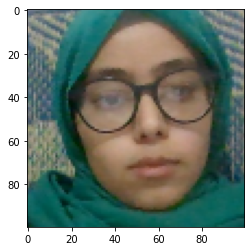

In [20]:
plt.imshow(img)

In [22]:
img.numpy().min() 

0.0

## 3.3 Create Labelled Dataset

In [23]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
samples = data.as_numpy_iterator()

In [13]:
example = samples.next()

In [14]:
example

(b'data\\anchor\\223b38f8-a664-11ee-a269-508140bf265d.jpg',
 b'data\\positive\\997c1803-a664-11ee-9a40-508140bf265d.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
res = preprocess_twin(*example)

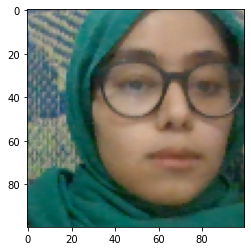

In [51]:
plt.imshow(res[1])

In [52]:
res[2]

1.0

In [13]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [14]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer


In [16]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [17]:
embedding = make_embedding()

In [18]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [19]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [20]:
l1 = L1Dist()

In [21]:
l1

## 4.3 Make Siamese Model

In [22]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [23]:
siamese_model = make_siamese_model()

In [24]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer


In [66]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [68]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints


In [69]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [77]:
test_batch = train_data.as_numpy_iterator()

In [80]:
batch_1 = test_batch.next()

In [81]:
X = batch_1[:2]

In [82]:
y = batch_1[2]

In [83]:
y

array([0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [84]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [85]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [86]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [87]:
EPOCHS = 50

In [88]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 73s 3s/step
0.707244 0.16431925 0.9722222

 Epoch 2/50
27/27 [==============================] - 69s 3s/step
0.18810976 0.77386934 0.9935484

 Epoch 3/50
27/27 [==============================] - 68s 2s/step
0.11723344 0.9460784 1.0

 Epoch 4/50
27/27 [==============================] - 70s 3s/step
0.30128574 0.98 1.0

 Epoch 5/50
27/27 [==============================] - 68s 3s/step
0.18363175 0.9852941 1.0

 Epoch 6/50
27/27 [==============================] - 68s 3s/step
0.0013567667 0.99502486 1.0

 Epoch 7/50
27/27 [==============================] - 68s 3s/step
0.0017656236 0.99 1.0

 Epoch 8/50
27/27 [==============================] - 67s 2s/step
0.00018346583 0.97 0.98477155

 Epoch 9/50
27/27 [==============================] - 67s 2s/step
0.00020682672 0.9905213 1.0

 Epoch 10/5

27/27 [==============================] - 67s 2s/step
0.00054403214 1.0 1.0

 Epoch 12/50
27/27 [==============================] - 67s 2s/step
0.043259904 1.0 1.0

 Epoch 13/50
27/27 [==============================] - 67s 2s/step
0.0018167183 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 67s 2s/step
0.01096796 0.99509805 1.0

 Epoch 15/50
27/27 [==============================] - 67s 2s/step
0.00068956905 1.0 1.0

 Epoch 16/50
27/27 [==============================] - 67s 2s/step
0.00039356618 1.0 1.0

 Epoch 17/50
27/27 [==============================] - 67s 2s/step
0.010888248 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 67s 2s/step
0.0 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 67s 2s/step
1.2815032e-06 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 67s 2s/step
0.00017341995 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 67s 2s/step
0.0081148725 1.0 1.0

 Epoch 22/50
1/1 [============================

27/27 [==============================] - 67s 2s/step
0.0009716839 1.0 1.0

 Epoch 23/50
27/27 [==============================] - 67s 2s/step
0.0 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 68s 2s/step
9.745536e-06 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 67s 2s/step
0.0002896675 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 67s 2s/step
2.41111e-05 1.0 1.0

 Epoch 27/50
27/27 [==============================] - 67s 2s/step
1.206997e-06 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 66s 2s/step
0.001022639 1.0 1.0

 Epoch 29/50
27/27 [==============================] - 67s 2s/step
1.4901161e-08 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 67s 2s/step
0.015910927 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 67s 2s/step
0.0016040057 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 67s 2s/step
4.7683756e-07 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 1s 

27/27 [==============================] - 67s 2s/step
1.1920932e-07 1.0 1.0

 Epoch 34/50
27/27 [==============================] - 67s 2s/step
0.00084633834 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 68s 2s/step
2.2351794e-06 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 65s 2s/step
5.287491e-05 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 53s 2s/step
0.00019348745 1.0 1.0

 Epoch 38/50
27/27 [==============================] - 55s 2s/step
1.4603179e-06 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 52s 2s/step
0.00023918806 1.0 1.0

 Epoch 40/50
27/27 [==============================] - 52s 2s/step
4.548248e-05 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 48s 2s/step
0.00047438036 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 51s 2s/step
0.0 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 0s 460ms/step


27/27 [==============================] - 51s 2s/step
0.0004178945 1.0 1.0

 Epoch 44/50
27/27 [==============================] - 52s 2s/step
0.00020255902 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 51s 2s/step
1.7881398e-07 1.0 1.0

 Epoch 46/50
27/27 [==============================] - 51s 2s/step
2.4139997e-06 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 50s 2s/step
8.672605e-06 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 51s 2s/step
0.00080935395 1.0 1.0

 Epoch 49/50
27/27 [==============================] - 51s 2s/step
2.0861634e-07 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 56s 2s/step
3.725318e-06 1.0 1.0


# 6. Evaluate Model

## 6.1 Import Metrics


In [89]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions


In [90]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [91]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 345ms/step


In [92]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [93]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [94]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [95]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 515ms/step
1.0 1.0


## 6.4 Viz Results

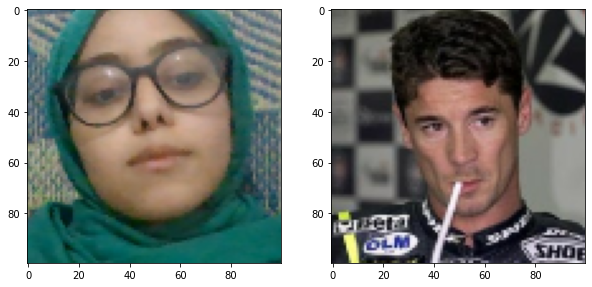

In [96]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model


In [97]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [98]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [99]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 538ms/step


array([[6.1041776e-11],
       [4.9101939e-13],
       [3.9444988e-08],
       [4.0877112e-05],
       [1.0000000e+00],
       [9.9999994e-01],
       [9.9990684e-01],
       [9.9964756e-01],
       [9.9999946e-01],
       [1.6634878e-12],
       [9.9999976e-01],
       [1.2296810e-11],
       [9.9857503e-01],
       [9.9999791e-01]], dtype=float32)

In [100]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [25]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [32]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 69ms/step
True
